# Camera Calibration
First finding image points and objpoint for all calibration images

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

#list of the calibration test images
cal_im_list = os.listdir("camera_cal/")

#just an index to go through the images manually 
i=3

#reading in an image
example_img = cv2.imread("camera_cal/"+cal_im_list[i])

# Convert to grayscale
gray = cv2.cvtColor(example_img, cv2.COLOR_BGR2GRAY)

#number of corners
nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    cv2.drawChessboardCorners(example_img, (nx, ny), corners, ret)
    plt.imshow(example_img)

#safe image    
#cv2.imwrite("output_images/chessboardcorners"+cal_im_list[i],example_img)


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

#find object points and image points for all images
for fname in cal_im_list:
    img = cv2.imread("camera_cal/"+fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # finding chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    #store object and image points to the lists
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        


Now calculate distortion matrix and undistort an image

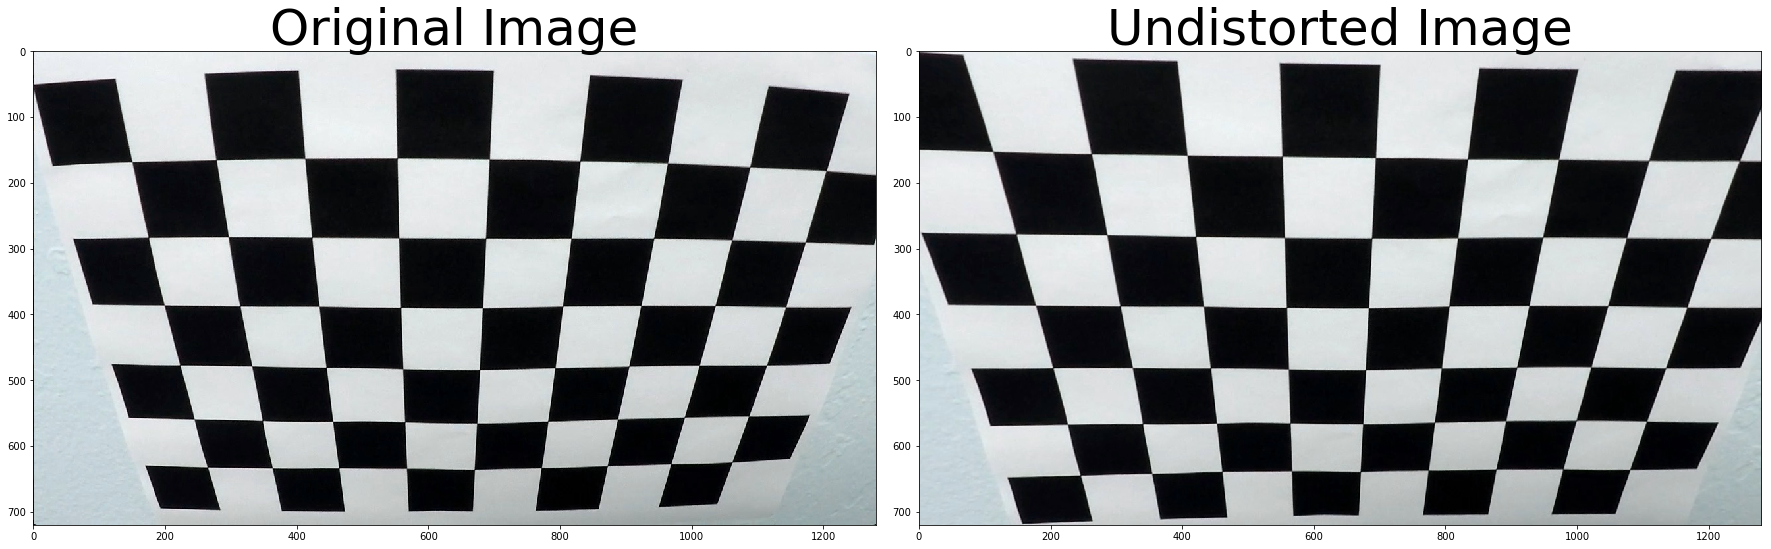

In [3]:
# cal_undistort performs the camera calibration, image distortion correction and 
# returns the undistorted image


# Read in an image
example_img = cv2.imread("camera_cal/"+cal_im_list[i])
example_gray = cv2.cvtColor(example_img,cv2.COLOR_BGR2GRAY)

#Camera calibration: calculate camera matrix, distortion coefficients etc.
et, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, example_img.shape[1:], None, None)

#undistort image with calculated parameters
undistorted = cv2.undistort(img, mtx, dist, None, mtx)


#plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#plt.savefig("output_images/undistorted"+cal_im_list[i])

# Undistort Test Images

['straight_lines1.jpg', 'test2.jpg', 'straight_lines2.jpg', 'test4.jpg', 'test1.jpg', 'test6.jpg', 'test5.jpg', 'test3.jpg']


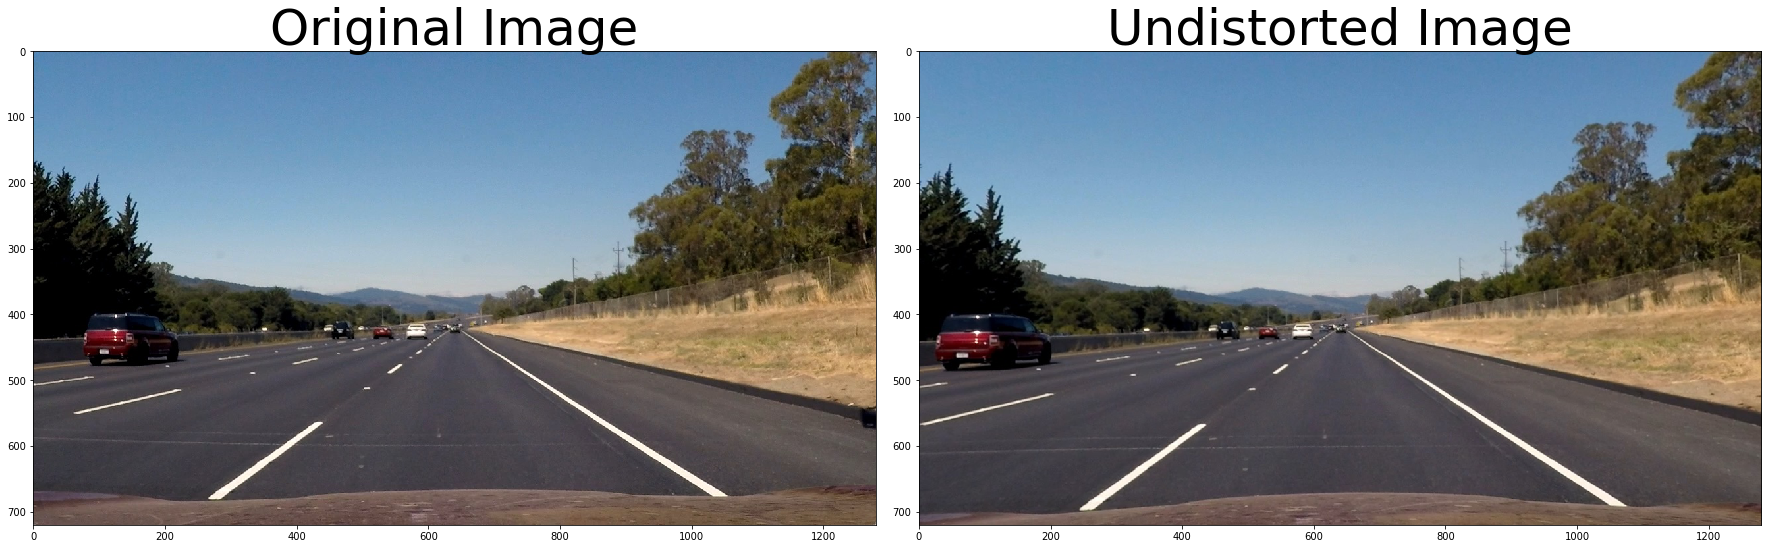

In [12]:
#undistort real images

#list of test images
test_im_list = os.listdir("test_images/")

print(test_im_list)

#just an index to go through the images manually 
#i=4
i=2

#reading in an image
#test_img = cv2.imread("test_images/"+test_im_list[i])
test_img = mpimg.imread("test_images/"+test_im_list[i])

#undistort test_image with calculated parameters fromabove
test_undistorted = cv2.undistort(test_img, mtx, dist, None, mtx)


#plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#plt.savefig("output_images/undistorted"+test_im_list[i])
#cv2.imwrite("output_images/undistorted_"+test_im_list[i],test_undistorted)


# Extracting a binary with pixels of lane markings and edges

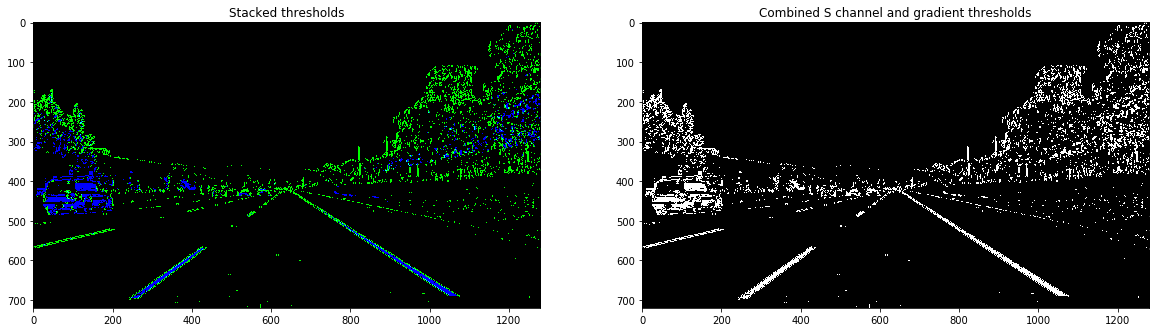

In [13]:
#function to apply thresholds to S-channel of HLS
def hls_s_select(input_img, thresh=(0, 255)):
    # convert RGB to HLS color space
    hls = cv2.cvtColor(input_img, cv2.COLOR_RGB2HLS)
    # select only S channel
    S = hls[:,:,2]
    # apply threshold to the S channel
    binary_S = np.zeros_like(S)
    binary_S[(S > thresh[0]) & (S <= thresh[1])] = 1
    # return binary
    return binary_S

#function to apply sobel-x L-channel of HLS
def hls_l_sobel_select(input_img, sx_thresh=(20, 100)):
    # convert RGB to HLS color space
    hls = cv2.cvtColor(input_img, cv2.COLOR_RGB2HLS)
    # select only L channel
    l_channel = hls[:,:,1]
    
    # Sobel x on L channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    lxbinary = np.zeros_like(scaled_sobel)
    lxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # return binary
    return lxbinary


#function to apply sobel x to grayscaled image
def sobelx_grayscale(input_img, thresh=(0, 255), sobel_kernel=3):
    # grayscale image
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # return binary
    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_xy = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    sobel_mag=np.sqrt(sobel_x**2 + 0.5*sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


#use undistorted image as image
#test_undistorted

#apply and play around with different filters und thresholds on test_undistorted

#hls_s_binary = hls_s_select(test_undistorted, thresh=(90, 255)) #s_thresh=(170, 255)
#hls_s_binary = hls_l_sobel_select(test_undistorted)
#hls_s_binary = sobelx_grayscale(test_undistorted, 3)
#hls_s_binary = mag_binary
#mag_binary = mag_thresh(test_undistorted, sobel_kernel=31, mag_thresh=(40, 100))
sxbinary = sobelx_grayscale(test_undistorted,(20, 100), sobel_kernel=3)
s_binary = hls_s_select(test_undistorted,(170,255))   #thresh=(90, 255)


# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

#plt.savefig("output_images/combined_binary"+test_im_list[i])

In [14]:
#define a function for finding lane pixels

def find_lane_binary(input_img):
    sxbinary = sobelx_grayscale(input_img,(20, 100), sobel_kernel=3)
    s_binary = hls_s_select(input_img,(170,255))   #thresh=(90, 255)
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    

# Transform perspective to birds eye view 

(1280, 720)


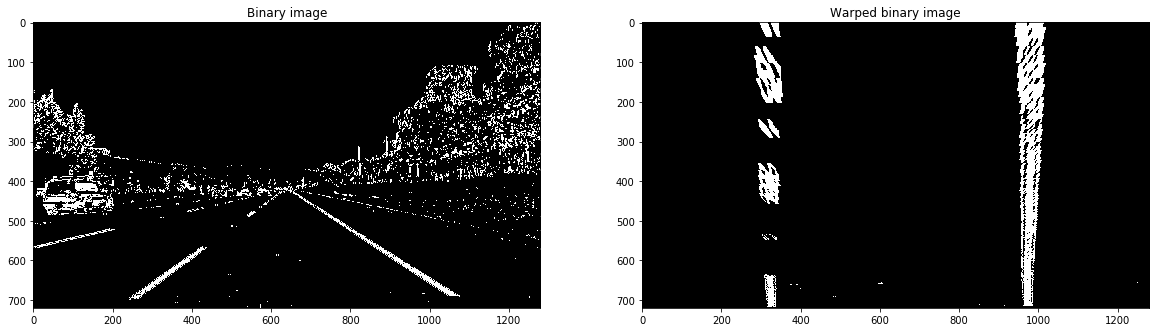

In [15]:
# image size width x height
img_size_warp=combined_binary.shape[:2]
img_size_warp=img_size_warp[::-1]

print(img_size_warp)

# source points manually meassured in undistorted straight_lines1
src=np.float32([[595,450],[686,450],[1071,706],[231,706]])

width= img_size_warp[0]
height= img_size_warp[1]

# take 25% of width as offset
offset = width*0.25

# define destination points 
dst = np.float32([[offset, 0],[width - offset, 0],[width - offset, height],[offset, height]])

# use cv2.getPerspectiveTransform() to get the transform matrix
M_warp = cv2.getPerspectiveTransform(src,dst)

# calculate inverse for backwards transform
M_warp_inv = cv2.getPerspectiveTransform(dst,src)


# warp image
warped = cv2.warpPerspective(combined_binary, M_warp, img_size_warp, flags=cv2.INTER_LINEAR)


# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Binary image')
ax1.imshow(combined_binary, cmap='gray')

ax2.set_title('Warped binary image')
ax2.imshow(warped, cmap='gray')

#plt.savefig("output_images/warped_"+test_im_list[i])

# Finding lane lines in transformed binary image

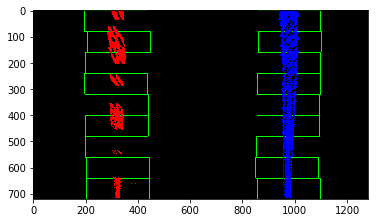

In [16]:
# apply on warped image in birds eye view
#warped


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # number of sliding windows
    nwindows = 9
    # width of the windows +/- margin
    margin = 120
    # minimum number of pixels found to recenter window
    minpix = 50

    # height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window 
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        

        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

                
        # If found > minpix pixels, recenter next window (`right` or `leftx_current`) on their mean position 
        if len(good_left_inds)>minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        ##
        #else:
        #    break
        
        if len(good_right_inds)>minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds])) 
        #else:
        #    break
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial_windows(binary_warped):
    # find lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    #Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit


out_img, left_fit, right_fit = fit_polynomial_windows(warped)

plt.imshow(out_img)

#plt.savefig("output_images/sliding_windows_"+test_im_list[i])

Search pixels around known polonomila of previous frame

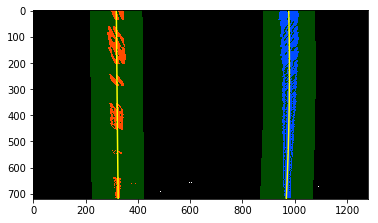

In [22]:
# apply on warped image in birds eye view
#warped

def search_around_poly(binary_warped, left_fit_prev, right_fit_prev):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values 
    # within the +/- margin of our polynomial function 
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
                    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
                    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))    
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
                    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
                    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))    
    
   
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
 
    img_shape = binary_warped.shape
    
    #Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    #Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result_img, left_fit, right_fit


out_img, left_fit, right_fit = search_around_poly(warped, left_fit, right_fit)

# View output
plt.imshow(out_img)

#plt.savefig("output_images/around_poly_"+test_im_list[i])

Sanity check

In [23]:
def check_lane_sanity(left_fit, right_fit):
    
    is_ok = True
    
    param0=abs(left_fit[0]/right_fit[0])
    param1=abs(left_fit[1]/right_fit[1])
    
    if param0>3 or param0<0.3:
        is_ok = False

    if param1>3 or param1<0.3:
        is_ok = False   
    
    ##check lane width
    
    img_shape = warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    #Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    width_pix= right_fitx[-1] - left_fitx[-1]
    
    if width_pix>750 or width_pix<450:
        is_ok = False
    
    return is_ok

print(check_lane_sanity(left_fit, right_fit))

False


# Projecting detected lanes back on undistorted image

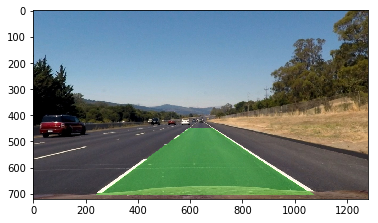

In [33]:
def project_lanes(left_fit,right_fit,orig_im):

    img_shape = warped.shape

    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    #Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_warp_inv, (test_undistorted.shape[1], test_undistorted.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_im, 1, newwarp, 0.3, 0)
    
    return result

projected = project_lanes(left_fit,right_fit,test_undistorted)
    
plt.imshow(projected)
plt.savefig("output_images/projected_"+test_im_list[i])

# Measuring curvature and offset

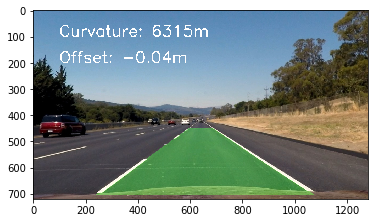

In [34]:
def measure_curvature_real(left_fit,right_fit,projected_img):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
    mid_fit = (left_fit+right_fit)/2
    
    
    fit_adj =[0,0,0]
    #scale fitted polynomial
    fit_adj[0] = mid_fit[0] * xm_per_pix/ (ym_per_pix**2)
    fit_adj[1] = mid_fit[1] * xm_per_pix/ym_per_pix
    fit_adj[2] = mid_fit[2]

    
    img_shape=projected_img.shape
    
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    #calculation of R_curve (radius of curvature) #####
    curverad = pow(1+(2*fit_adj[0]*y_eval+fit_adj[1])**2,3/2)/abs(2*fit_adj[0])   
    
    
    #calculation of offset
    
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    #lane center is middle betwenn bottom points of the fitted lines
    lane_center_pix=(left_fitx[-1]+right_fitx[-1])/2
    
    #calculate offset in pixels
    offset_pix= warped.shape[1]/2-lane_center_pix
    
    #convert to offset in meters
    offset_m= offset_pix * xm_per_pix
    
    
    #print curve radius on image
    cv2.putText(projected_img,'Curvature: ' +str(int(curverad)) + 'm',(100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3 )
    cv2.putText(projected_img,'Offset: ' +str(round(offset_m,2)) + 'm',(100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3 )
    
    return projected_img




# Calculate the radius of curvature in meters for both lane lines
printed_img = measure_curvature_real(left_fit, right_fit, projected)

plt.imshow(printed_img)



# Pipeline: Putting all togeather

In [35]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.ok = False
        #times of failed sanity checks in a row
        self.times_nok=100
        # values of the last n fits of the line
        self.recent_fitted =[] 
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
       


In [38]:
# defining a pipeline to use on eacht frame of the video

left_line_obj = Line()
right_line_obj = Line()

def pipeline (frame): 
    
    #undistort each frame with parameters found with the calibration images
    undistorted_frame = cv2.undistort(frame, mtx, dist, None, mtx)
    
    # find lane pixels in the undistorted frames
    frame_lane_pix = find_lane_binary(undistorted_frame)
    
    #transform the binary lane pixels to birds eye view
    warped_frame = cv2.warpPerspective(frame_lane_pix, M_warp, img_size_warp, flags=cv2.INTER_LINEAR)
    
    #fin lane lines in warped frame
    if left_line_obj.times_nok<10:
        out_img, left_current_fit, right_current_fit = search_around_poly(warped_frame, left_line_obj.current_fit, right_line_obj.current_fit)
    else:
        out_img, left_current_fit, right_current_fit = fit_polynomial_windows(warped_frame)
        
    
    #store lane sanity
    if check_lane_sanity(left_current_fit, right_current_fit):
        left_line_obj.times_nok = 0
    else:
        left_line_obj.times_nok += 1
        print(left_line_obj.times_nok)
    
    #store all fitted polynoms
    left_line_obj.recent_fitted.append(left_current_fit)
    right_line_obj.recent_fitted.append(right_current_fit)
    
    #select the las n fitted polynomials
    last_fits_l= left_line_obj.recent_fitted[-8:]
    last_fits_r= right_line_obj.recent_fitted[-8:]
    
    #smoothen over the last n polynoms
    left_line_obj.current_fit = np.average(last_fits_l, axis=0)
    right_line_obj.current_fit = np.average(last_fits_r, axis=0)
    
    ############
    
    #project the found lanes on original undistorted frame
    projected = project_lanes(left_line_obj.current_fit,right_line_obj.current_fit,undistorted_frame)
    
    #pint measured curvature and offset on the frame
    printed_img = measure_curvature_real(left_line_obj.current_fit, right_line_obj.current_fit, projected)
    
 
    result = printed_img
     
    return result

101


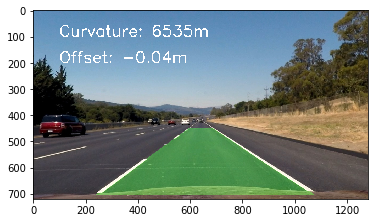

In [39]:
# test pipiline on single frame

processed_img= pipeline(test_img)

plt.imshow(processed_img)

# Apply pipeline to videos

In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video solved_project_video.mp4
[MoviePy] Writing video solved_project_video.mp4


 24%|██▍       | 307/1261 [00:57<03:04,  5.18it/s]

1


 25%|██▍       | 310/1261 [00:58<03:08,  5.05it/s]

1


 25%|██▍       | 311/1261 [00:58<03:25,  4.62it/s]

2
3


 25%|██▍       | 313/1261 [00:59<03:13,  4.90it/s]

4
5

 25%|██▍       | 314/1261 [00:59<03:14,  4.87it/s]


6


 25%|██▌       | 316/1261 [00:59<03:14,  4.86it/s]

7


 25%|██▌       | 317/1261 [01:00<03:19,  4.73it/s]

8
9


 25%|██▌       | 320/1261 [01:00<02:56,  5.32it/s]

10
11


 26%|██▌       | 322/1261 [01:00<02:51,  5.49it/s]

12
13


 26%|██▌       | 324/1261 [01:01<02:47,  5.61it/s]

14
15


 26%|██▌       | 326/1261 [01:01<02:44,  5.67it/s]

16
17


 26%|██▌       | 327/1261 [01:01<02:52,  5.42it/s]

18
19


 26%|██▌       | 329/1261 [01:02<02:51,  5.44it/s]

20
21


 26%|██▋       | 332/1261 [01:02<02:48,  5.50it/s]

1


 26%|██▋       | 333/1261 [01:02<02:59,  5.18it/s]

2
3


 27%|██▋       | 336/1261 [01:03<02:51,  5.41it/s]

1


 27%|██▋       | 341/1261 [01:04<02:59,  5.13it/s]

1
2


 27%|██▋       | 343/1261 [01:04<03:00,  5.09it/s]

3
4


 27%|██▋       | 345/1261 [01:05<03:02,  5.01it/s]

5
6


 28%|██▊       | 347/1261 [01:05<02:57,  5.14it/s]

7
8


 28%|██▊       | 349/1261 [01:06<02:57,  5.15it/s]

9
10


 28%|██▊       | 351/1261 [01:06<02:53,  5.24it/s]

11
12


 28%|██▊       | 353/1261 [01:06<02:56,  5.14it/s]

13
14


 28%|██▊       | 355/1261 [01:07<02:55,  5.15it/s]

15
16


 29%|██▊       | 362/1261 [01:08<02:52,  5.20it/s]

1


 29%|██▉       | 363/1261 [01:08<03:01,  4.96it/s]

2
3


 29%|██▉       | 365/1261 [01:09<02:58,  5.02it/s]

4
5


 29%|██▉       | 367/1261 [01:09<03:03,  4.88it/s]

6
7


 30%|██▉       | 374/1261 [01:10<03:01,  4.90it/s]

1


 30%|██▉       | 375/1261 [01:11<03:07,  4.73it/s]

2


 30%|██▉       | 378/1261 [01:11<02:56,  5.01it/s]

1


 30%|███       | 379/1261 [01:11<03:03,  4.80it/s]

2


 30%|███       | 381/1261 [01:12<02:58,  4.92it/s]

1


 30%|███       | 383/1261 [01:12<03:05,  4.73it/s]

1
2


 31%|███       | 385/1261 [01:13<03:01,  4.83it/s]

3
4


 31%|███       | 387/1261 [01:13<03:02,  4.79it/s]

5


 31%|███       | 390/1261 [01:14<02:59,  4.85it/s]

1


 31%|███       | 391/1261 [01:14<03:05,  4.70it/s]

2


 31%|███▏      | 395/1261 [01:15<03:02,  4.75it/s]

1
2


 31%|███▏      | 397/1261 [01:15<03:00,  4.78it/s]

3
4


 32%|███▏      | 399/1261 [01:16<02:58,  4.83it/s]

5
6


 32%|███▏      | 401/1261 [01:16<02:54,  4.93it/s]

7
8


 32%|███▏      | 403/1261 [01:16<02:56,  4.85it/s]

9


 32%|███▏      | 405/1261 [01:17<02:59,  4.76it/s]

1


 32%|███▏      | 406/1261 [01:17<02:55,  4.86it/s]

2


 32%|███▏      | 407/1261 [01:17<03:00,  4.72it/s]

3


 32%|███▏      | 408/1261 [01:17<02:54,  4.90it/s]

4


 33%|███▎      | 410/1261 [01:18<02:52,  4.92it/s]

1


 33%|███▎      | 411/1261 [01:18<02:57,  4.78it/s]

2
3


 33%|███▎      | 414/1261 [01:19<02:51,  4.95it/s]

1


 33%|███▎      | 416/1261 [01:19<02:52,  4.91it/s]

1
2

 33%|███▎      | 417/1261 [01:19<02:57,  4.76it/s]

 33%|███▎      | 420/1261 [01:20<02:52,  4.88it/s]

1
2


 34%|███▍      | 427/1261 [01:21<02:44,  5.06it/s]

1


 34%|███▍      | 429/1261 [01:22<02:44,  5.06it/s]

1
2


 34%|███▍      | 431/1261 [01:22<02:44,  5.06it/s]

3
4


 34%|███▍      | 433/1261 [01:22<02:45,  5.01it/s]

5


 35%|███▍      | 439/1261 [01:24<02:40,  5.13it/s]

1


 35%|███▍      | 441/1261 [01:24<02:44,  4.99it/s]

1


 36%|███▌      | 449/1261 [01:26<02:46,  4.86it/s]

1
2


 36%|███▌      | 453/1261 [01:26<02:45,  4.88it/s]

1


 36%|███▌      | 456/1261 [01:27<02:39,  5.06it/s]

1


 36%|███▋      | 460/1261 [01:28<02:41,  4.96it/s]

1


 37%|███▋      | 461/1261 [01:28<02:46,  4.80it/s]

2
3


 37%|███▋      | 463/1261 [01:28<02:48,  4.75it/s]

4


 37%|███▋      | 464/1261 [01:29<02:43,  4.87it/s]

5


 37%|███▋      | 465/1261 [01:29<02:49,  4.69it/s]

6
7


 37%|███▋      | 467/1261 [01:29<02:47,  4.75it/s]

8


 37%|███▋      | 469/1261 [01:30<02:47,  4.72it/s]

1
2


 37%|███▋      | 471/1261 [01:30<02:45,  4.76it/s]

3
4


 38%|███▊      | 473/1261 [01:31<02:44,  4.80it/s]

5


 38%|███▊      | 481/1261 [01:32<03:14,  4.02it/s]

1


 38%|███▊      | 482/1261 [01:33<03:24,  3.80it/s]

2


 38%|███▊      | 483/1261 [01:33<03:39,  3.54it/s]

3


 38%|███▊      | 484/1261 [01:33<03:42,  3.49it/s]

4


 38%|███▊      | 485/1261 [01:34<03:52,  3.34it/s]

5


 39%|███▊      | 486/1261 [01:34<03:26,  3.75it/s]

6


 39%|███▊      | 488/1261 [01:34<02:53,  4.46it/s]

1


 39%|███▉      | 490/1261 [01:35<02:37,  4.90it/s]

1


 39%|███▉      | 492/1261 [01:35<02:32,  5.04it/s]

1


 39%|███▉      | 494/1261 [01:35<02:30,  5.10it/s]

1


 39%|███▉      | 495/1261 [01:36<02:35,  4.92it/s]

2
3


 39%|███▉      | 498/1261 [01:36<02:26,  5.21it/s]

4


 40%|███▉      | 500/1261 [01:36<02:27,  5.14it/s]

1


 40%|███▉      | 501/1261 [01:37<02:35,  4.89it/s]

2


 40%|███▉      | 503/1261 [01:37<02:35,  4.89it/s]

1
2


 40%|████      | 506/1261 [01:38<02:28,  5.08it/s]

1


 40%|████      | 508/1261 [01:38<02:27,  5.10it/s]

1


 40%|████      | 509/1261 [01:38<02:35,  4.84it/s]

2
3


 41%|████      | 511/1261 [01:39<02:36,  4.78it/s]

4
5


 41%|████      | 513/1261 [01:39<02:37,  4.76it/s]

6


 41%|████      | 516/1261 [01:40<02:26,  5.09it/s]

1


 41%|████      | 517/1261 [01:40<02:33,  4.85it/s]

2
3


 41%|████      | 519/1261 [01:40<02:33,  4.82it/s]

4


 41%|████▏     | 521/1261 [01:41<02:34,  4.78it/s]

1


 41%|████▏     | 523/1261 [01:41<02:34,  4.77it/s]

1


 42%|████▏     | 524/1261 [01:41<02:31,  4.88it/s]

2


 42%|████▏     | 525/1261 [01:42<02:35,  4.75it/s]

3
4


 42%|████▏     | 530/1261 [01:43<02:29,  4.89it/s]

1


 42%|████▏     | 531/1261 [01:43<02:33,  4.75it/s]

2
3


 42%|████▏     | 533/1261 [01:43<02:32,  4.79it/s]

4


 42%|████▏     | 534/1261 [01:43<02:28,  4.91it/s]

5


 42%|████▏     | 535/1261 [01:44<02:32,  4.77it/s]

6


 43%|████▎     | 536/1261 [01:44<02:28,  4.89it/s]

7


 43%|████▎     | 537/1261 [01:44<02:31,  4.76it/s]

8


 43%|████▎     | 539/1261 [01:45<02:30,  4.80it/s]

1


 43%|████▎     | 540/1261 [01:45<02:27,  4.88it/s]

2
3

 43%|████▎     | 541/1261 [01:45<02:31,  4.76it/s]


4


 43%|████▎     | 543/1261 [01:45<02:23,  5.01it/s]

5
6


 44%|████▍     | 555/1261 [01:48<02:25,  4.86it/s]

1
2


 44%|████▍     | 557/1261 [01:48<02:24,  4.86it/s]

3


 44%|████▍     | 558/1261 [01:48<02:31,  4.64it/s]

4


 44%|████▍     | 559/1261 [01:49<02:27,  4.76it/s]

5


 44%|████▍     | 560/1261 [01:49<02:32,  4.59it/s]

6


 44%|████▍     | 561/1261 [01:49<02:27,  4.73it/s]

7


 45%|████▍     | 563/1261 [01:49<02:28,  4.71it/s]

1


 45%|████▍     | 565/1261 [01:50<02:26,  4.76it/s]

1


 45%|████▍     | 566/1261 [01:50<02:31,  4.58it/s]

2


 45%|████▌     | 568/1261 [01:51<02:31,  4.57it/s]

1


 45%|████▌     | 569/1261 [01:51<02:27,  4.69it/s]

2


 46%|████▌     | 575/1261 [01:52<02:27,  4.67it/s]

1
2


 46%|████▌     | 577/1261 [01:52<02:24,  4.73it/s]

3
4

 46%|████▌     | 578/1261 [01:53<02:30,  4.55it/s]

 46%|████▌     | 580/1261 [01:53<02:29,  4.55it/s]

1


 47%|████▋     | 588/1261 [01:55<02:26,  4.59it/s]

1


 47%|████▋     | 589/1261 [01:55<02:21,  4.75it/s]

2


 47%|████▋     | 594/1261 [01:56<02:19,  4.79it/s]

1


 47%|████▋     | 595/1261 [01:56<02:24,  4.61it/s]

2


 47%|████▋     | 596/1261 [01:57<02:20,  4.74it/s]

3


 76%|███████▌  | 954/1261 [03:09<01:02,  4.93it/s]

1


 77%|███████▋  | 972/1261 [03:13<00:58,  4.93it/s]

1


 77%|███████▋  | 973/1261 [03:13<01:00,  4.73it/s]

2


 77%|███████▋  | 974/1261 [03:14<00:59,  4.86it/s]

3


 77%|███████▋  | 977/1261 [03:14<00:59,  4.80it/s]

1
2


 78%|███████▊  | 979/1261 [03:15<00:57,  4.88it/s]

3


 78%|███████▊  | 987/1261 [03:16<00:56,  4.84it/s]

1


 78%|███████▊  | 989/1261 [03:17<00:56,  4.81it/s]

1


 79%|███████▊  | 991/1261 [03:17<00:56,  4.74it/s]

1


 79%|███████▊  | 993/1261 [03:17<00:55,  4.83it/s]

1


 79%|███████▉  | 994/1261 [03:18<00:56,  4.74it/s]

2


 80%|████████  | 1012/1261 [03:22<00:58,  4.29it/s]

1


 80%|████████  | 1013/1261 [03:22<00:56,  4.41it/s]

2


 83%|████████▎ | 1048/1261 [03:30<00:49,  4.26it/s]

1


 83%|████████▎ | 1049/1261 [03:30<00:52,  4.04it/s]

2


 83%|████████▎ | 1050/1261 [03:30<00:50,  4.21it/s]

3


 98%|█████████▊| 1242/1261 [04:12<00:04,  4.69it/s]

1


 99%|█████████▊| 1243/1261 [04:12<00:03,  4.84it/s]

2


 99%|█████████▉| 1253/1261 [04:14<00:01,  5.15it/s]

1


 99%|█████████▉| 1254/1261 [04:14<00:01,  4.78it/s]

2


100%|█████████▉| 1257/1261 [04:15<00:00,  4.92it/s]

1


100%|█████████▉| 1258/1261 [04:15<00:00,  4.77it/s]

2
3


100%|█████████▉| 1260/1261 [04:16<00:00,  4.81it/s]

4


[MoviePy] Done.
[MoviePy] >>>> Video ready: solved_project_video.mp4 

CPU times: user 1min 57s, sys: 17.5 s, total: 2min 14s
Wall time: 4min 19s


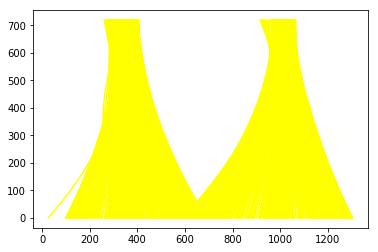

In [41]:
video_output = 'solved_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
processed_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(video_output, audio=False)

In [42]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(video_output))

Challenge Video

6
[MoviePy] >>>> Building video solved_challenge_video.mp4
[MoviePy] Writing video solved_challenge_video.mp4



  0%|          | 1/485 [00:00<01:03,  7.68it/s]

7



  0%|          | 2/485 [00:00<01:07,  7.19it/s]

8



  1%|          | 3/485 [00:00<01:06,  7.23it/s]

9



  1%|          | 4/485 [00:00<01:05,  7.33it/s]

10



  1%|          | 5/485 [00:00<01:04,  7.47it/s]

11



  1%|          | 6/485 [00:00<01:03,  7.58it/s]

12



  1%|▏         | 7/485 [00:00<01:02,  7.64it/s]

13



  2%|▏         | 8/485 [00:01<01:02,  7.69it/s]

14



  5%|▍         | 22/485 [00:02<01:01,  7.49it/s]

1



  5%|▌         | 25/485 [00:03<01:00,  7.54it/s]

1
2



  6%|▌         | 30/485 [00:03<00:59,  7.61it/s]

1
2



  7%|▋         | 32/485 [00:04<00:59,  7.59it/s]

3
4



  7%|▋         | 34/485 [00:04<00:59,  7.54it/s]

5
6



  7%|▋         | 36/485 [00:04<00:59,  7.50it/s]

7
8



  8%|▊         | 38/485 [00:05<00:58,  7.60it/s]

9
10



  8%|▊         | 41/485 [00:05<00:58,  7.55it/s]

1
2



  9%|▊         | 42/485 [00:05<00:58,  7.63it/s]

3
4



  9%|▉         | 45/485 [00:06<01:31,  4.80it/s]

5
6



  9%|▉         | 46/485 [00:06<01:35,  4.61it/s]

7



 10%|▉         | 47/485 [00:06<01:31,  4.78it/s]

8



 10%|█         | 50/485 [00:07<01:34,  4.61it/s]

1



 11%|█         | 53/485 [00:08<01:33,  4.62it/s]

1



 11%|█         | 54/485 [00:08<01:37,  4.44it/s]

2



 11%|█▏        | 55/485 [00:08<01:33,  4.60it/s]

3
4



 12%|█▏        | 57/485 [00:09<01:34,  4.53it/s]

5



 12%|█▏        | 58/485 [00:09<01:31,  4.66it/s]

6



 12%|█▏        | 59/485 [00:09<01:30,  4.73it/s]

7



 12%|█▏        | 60/485 [00:09<01:35,  4.46it/s]

8



 13%|█▎        | 61/485 [00:09<01:31,  4.62it/s]

9
10



 13%|█▎        | 63/485 [00:10<01:31,  4.61it/s]

11



 13%|█▎        | 65/485 [00:10<01:26,  4.86it/s]

1



 14%|█▎        | 66/485 [00:10<01:30,  4.60it/s]

2



 14%|█▍        | 67/485 [00:11<01:27,  4.76it/s]

3
4



 14%|█▍        | 69/485 [00:11<01:29,  4.64it/s]

5



 14%|█▍        | 70/485 [00:11<01:27,  4.76it/s]

6
7



 15%|█▍        | 72/485 [00:12<01:30,  4.56it/s]

8



 15%|█▌        | 73/485 [00:12<01:28,  4.65it/s]

9



 15%|█▌        | 74/485 [00:12<01:31,  4.47it/s]

10



 15%|█▌        | 75/485 [00:12<01:26,  4.72it/s]

11
12



 16%|█▌        | 77/485 [00:13<01:27,  4.68it/s]

13



 16%|█▌        | 78/485 [00:13<01:24,  4.80it/s]

14
15



 16%|█▋        | 80/485 [00:13<01:25,  4.74it/s]

16



 17%|█▋        | 82/485 [00:14<01:21,  4.93it/s]

1



 17%|█▋        | 83/485 [00:14<01:26,  4.63it/s]

2



 17%|█▋        | 84/485 [00:14<01:25,  4.71it/s]

3
4



 18%|█▊        | 86/485 [00:15<01:25,  4.66it/s]

5



 18%|█▊        | 87/485 [00:15<01:23,  4.76it/s]

6
7



 18%|█▊        | 89/485 [00:15<01:25,  4.62it/s]

8



 19%|█▊        | 90/485 [00:16<01:24,  4.65it/s]

9
10



 19%|█▉        | 92/485 [00:16<01:24,  4.65it/s]

11



 19%|█▉        | 93/485 [00:16<01:20,  4.89it/s]

12
13



 20%|█▉        | 95/485 [00:17<01:17,  5.02it/s]

14
15



 20%|██        | 97/485 [00:17<01:17,  5.01it/s]

16
17



 20%|██        | 99/485 [00:17<01:18,  4.90it/s]

18
19



 21%|██        | 101/485 [00:18<01:20,  4.78it/s]

20



 21%|██        | 102/485 [00:18<01:17,  4.94it/s]

21
22


 21%|██        | 103/485 [00:18<01:20,  4.75it/s]


 21%|██▏       | 104/485 [00:18<01:21,  4.65it/s]

23



 22%|██▏       | 105/485 [00:19<01:18,  4.83it/s]

24
25



 22%|██▏       | 107/485 [00:19<01:18,  4.84it/s]

26
27



 22%|██▏       | 109/485 [00:19<01:16,  4.89it/s]

28
29



 23%|██▎       | 111/485 [00:20<01:16,  4.89it/s]

30
31


 23%|██▎       | 112/485 [00:20<01:18,  4.77it/s]


 23%|██▎       | 113/485 [00:20<01:15,  4.93it/s]

32



 24%|██▎       | 114/485 [00:20<01:17,  4.76it/s]

33



 24%|██▎       | 115/485 [00:21<01:14,  4.97it/s]

34
35



 24%|██▍       | 117/485 [00:21<01:14,  4.96it/s]

36
37



 25%|██▍       | 119/485 [00:21<01:13,  5.00it/s]

38
39


 25%|██▍       | 120/485 [00:22<01:14,  4.91it/s]


 25%|██▌       | 122/485 [00:22<01:13,  4.95it/s]

1



 28%|██▊       | 135/485 [00:25<01:16,  4.57it/s]

1



 28%|██▊       | 136/485 [00:25<01:13,  4.75it/s]

2



 28%|██▊       | 137/485 [00:25<01:15,  4.58it/s]

3



 28%|██▊       | 138/485 [00:25<01:15,  4.62it/s]

4



 29%|██▊       | 139/485 [00:26<01:16,  4.54it/s]

5



 29%|██▉       | 140/485 [00:26<01:13,  4.69it/s]

6



 29%|██▉       | 141/485 [00:26<01:16,  4.51it/s]

7



 29%|██▉       | 142/485 [00:26<01:13,  4.67it/s]

8



 29%|██▉       | 143/485 [00:27<01:15,  4.55it/s]

9



 30%|██▉       | 144/485 [00:27<01:12,  4.68it/s]

10



 30%|███       | 146/485 [00:27<01:11,  4.73it/s]

1



 30%|███       | 147/485 [00:27<01:13,  4.57it/s]

2



 31%|███       | 148/485 [00:28<01:11,  4.72it/s]

3



 31%|███       | 149/485 [00:28<01:14,  4.51it/s]

4



 31%|███       | 150/485 [00:28<01:12,  4.65it/s]

5



 31%|███       | 151/485 [00:28<01:13,  4.56it/s]

6



 31%|███▏      | 152/485 [00:29<01:13,  4.51it/s]

7



 32%|███▏      | 153/485 [00:29<01:14,  4.48it/s]

8



 32%|███▏      | 154/485 [00:29<01:17,  4.26it/s]

9



 32%|███▏      | 155/485 [00:29<01:18,  4.23it/s]

10



 32%|███▏      | 157/485 [00:30<01:16,  4.31it/s]

1



 33%|███▎      | 158/485 [00:30<01:17,  4.22it/s]

2



 33%|███▎      | 159/485 [00:30<01:15,  4.29it/s]

3



 33%|███▎      | 160/485 [00:30<01:14,  4.34it/s]

4



 33%|███▎      | 161/485 [00:31<01:13,  4.40it/s]

5



 33%|███▎      | 162/485 [00:31<01:14,  4.33it/s]

6



 34%|███▎      | 163/485 [00:31<01:14,  4.32it/s]

7



 34%|███▍      | 164/485 [00:31<01:15,  4.28it/s]

8



 34%|███▍      | 165/485 [00:32<01:14,  4.31it/s]

9



 34%|███▍      | 166/485 [00:32<01:15,  4.24it/s]

10



 35%|███▍      | 168/485 [00:32<01:12,  4.36it/s]

1



 35%|███▍      | 169/485 [00:33<01:12,  4.37it/s]

2



 35%|███▌      | 170/485 [00:33<01:11,  4.40it/s]

3



 35%|███▌      | 171/485 [00:33<01:11,  4.39it/s]

4



 35%|███▌      | 172/485 [00:33<01:11,  4.39it/s]

5



 36%|███▌      | 173/485 [00:33<01:12,  4.32it/s]

6



 36%|███▌      | 174/485 [00:34<01:11,  4.34it/s]

7



 36%|███▌      | 175/485 [00:34<01:10,  4.38it/s]

8



 36%|███▋      | 176/485 [00:34<01:10,  4.40it/s]

9



 36%|███▋      | 177/485 [00:34<01:09,  4.42it/s]

10



 37%|███▋      | 179/485 [00:35<01:09,  4.38it/s]

1



 37%|███▋      | 180/485 [00:35<01:09,  4.36it/s]

2



 37%|███▋      | 181/485 [00:35<01:09,  4.34it/s]

3



 38%|███▊      | 182/485 [00:35<01:09,  4.33it/s]

4



 38%|███▊      | 183/485 [00:36<01:10,  4.28it/s]

5



 38%|███▊      | 184/485 [00:36<01:10,  4.29it/s]

6



 38%|███▊      | 185/485 [00:36<01:09,  4.30it/s]

7



 38%|███▊      | 186/485 [00:36<01:09,  4.32it/s]

8



 39%|███▊      | 187/485 [00:37<01:08,  4.36it/s]

9



 39%|███▉      | 188/485 [00:37<01:07,  4.39it/s]

10



 39%|███▉      | 189/485 [00:37<01:06,  4.44it/s]

11



 39%|███▉      | 190/485 [00:37<01:05,  4.49it/s]

12



 39%|███▉      | 191/485 [00:38<01:06,  4.39it/s]

13



 40%|███▉      | 192/485 [00:38<01:02,  4.66it/s]

14



 40%|███▉      | 193/485 [00:38<01:05,  4.44it/s]

15



 40%|████      | 194/485 [00:38<01:01,  4.71it/s]

16



 40%|████      | 195/485 [00:38<01:04,  4.49it/s]

17



 40%|████      | 196/485 [00:39<01:01,  4.73it/s]

18



 41%|████      | 197/485 [00:39<01:04,  4.49it/s]

19



 41%|████      | 198/485 [00:39<01:00,  4.72it/s]

20



 41%|████      | 199/485 [00:39<01:03,  4.54it/s]

21



 41%|████      | 200/485 [00:39<01:02,  4.54it/s]

22



 41%|████▏     | 201/485 [00:40<01:02,  4.52it/s]

23



 42%|████▏     | 204/485 [00:40<01:02,  4.49it/s]

1



 43%|████▎     | 208/485 [00:41<00:58,  4.70it/s]

1



 67%|██████▋   | 326/485 [01:07<00:38,  4.16it/s]

1



 67%|██████▋   | 327/485 [01:07<00:37,  4.20it/s]

2
3



 68%|██████▊   | 329/485 [01:08<00:35,  4.45it/s]

4



 68%|██████▊   | 330/485 [01:08<00:34,  4.55it/s]

5



 68%|██████▊   | 331/485 [01:08<00:34,  4.46it/s]

6
7



 70%|███████   | 340/485 [01:10<00:30,  4.69it/s]

1



 70%|███████   | 341/485 [01:10<00:31,  4.62it/s]

2



 71%|███████▏  | 346/485 [01:11<00:29,  4.79it/s]

1



 72%|███████▏  | 347/485 [01:12<00:29,  4.63it/s]

2
3



 72%|███████▏  | 349/485 [01:12<00:29,  4.65it/s]

4



 73%|███████▎  | 352/485 [01:13<00:27,  4.75it/s]

1



 73%|███████▎  | 353/485 [01:13<00:27,  4.86it/s]

2



 73%|███████▎  | 354/485 [01:13<00:29,  4.43it/s]

3



 73%|███████▎  | 355/485 [01:13<00:29,  4.44it/s]

4



 73%|███████▎  | 356/485 [01:14<00:30,  4.18it/s]

5



 74%|███████▎  | 357/485 [01:14<00:29,  4.31it/s]

6



 74%|███████▍  | 358/485 [01:14<00:29,  4.24it/s]

7
8



 74%|███████▍  | 360/485 [01:14<00:29,  4.23it/s]

9



 74%|███████▍  | 361/485 [01:15<00:28,  4.41it/s]

10



 75%|███████▍  | 362/485 [01:15<00:28,  4.32it/s]

11
12



 75%|███████▌  | 364/485 [01:15<00:26,  4.56it/s]

13
14



 75%|███████▌  | 366/485 [01:16<00:25,  4.66it/s]

15
16



 76%|███████▌  | 368/485 [01:16<00:24,  4.69it/s]

17
18



 76%|███████▋  | 371/485 [01:17<00:23,  4.88it/s]

1



 80%|████████  | 389/485 [01:21<00:22,  4.21it/s]

1



 83%|████████▎ | 401/485 [01:24<00:18,  4.59it/s]

1



 83%|████████▎ | 403/485 [01:24<00:18,  4.33it/s]

1



 83%|████████▎ | 404/485 [01:25<00:18,  4.43it/s]

2



 84%|████████▎ | 405/485 [01:25<00:18,  4.24it/s]

3



 84%|████████▍ | 408/485 [01:26<00:18,  4.25it/s]

1



 85%|████████▍ | 410/485 [01:26<00:17,  4.24it/s]

1
2



 85%|████████▍ | 412/485 [01:26<00:17,  4.23it/s]

3



 85%|████████▌ | 413/485 [01:27<00:16,  4.34it/s]

4



 85%|████████▌ | 414/485 [01:27<00:16,  4.40it/s]

5



 86%|████████▌ | 415/485 [01:27<00:16,  4.13it/s]

6



 86%|████████▌ | 417/485 [01:28<00:15,  4.40it/s]

1



 86%|████████▌ | 418/485 [01:28<00:15,  4.28it/s]

2



 87%|████████▋ | 420/485 [01:28<00:15,  4.27it/s]

1



 87%|████████▋ | 421/485 [01:29<00:14,  4.39it/s]

2



 87%|████████▋ | 422/485 [01:29<00:15,  4.17it/s]

3



 87%|████████▋ | 423/485 [01:29<00:14,  4.30it/s]

4



 87%|████████▋ | 424/485 [01:29<00:13,  4.42it/s]

5



 88%|████████▊ | 425/485 [01:29<00:14,  4.19it/s]

6



 88%|████████▊ | 426/485 [01:30<00:13,  4.31it/s]

7



 88%|████████▊ | 427/485 [01:30<00:13,  4.40it/s]

8



 88%|████████▊ | 428/485 [01:30<00:13,  4.18it/s]

9



 88%|████████▊ | 429/485 [01:30<00:13,  4.28it/s]

10



 89%|████████▊ | 430/485 [01:31<00:12,  4.45it/s]

11



 89%|████████▉ | 431/485 [01:31<00:12,  4.32it/s]

12
13



 89%|████████▉ | 433/485 [01:31<00:11,  4.40it/s]

14
15


 89%|████████▉ | 434/485 [01:31<00:11,  4.61it/s]


 90%|████████▉ | 435/485 [01:32<00:11,  4.40it/s]

16



 90%|████████▉ | 436/485 [01:32<00:10,  4.56it/s]

17
18



 90%|█████████ | 438/485 [01:32<00:10,  4.47it/s]

19



 91%|█████████ | 439/485 [01:33<00:10,  4.54it/s]

20



 91%|█████████ | 440/485 [01:33<00:09,  4.69it/s]

21



 91%|█████████ | 441/485 [01:33<00:09,  4.42it/s]

22



 91%|█████████ | 442/485 [01:33<00:09,  4.51it/s]

23



 91%|█████████▏| 443/485 [01:33<00:09,  4.58it/s]

24



 92%|█████████▏| 444/485 [01:34<00:09,  4.34it/s]

25



 92%|█████████▏| 445/485 [01:34<00:09,  4.43it/s]

26



 92%|█████████▏| 446/485 [01:34<00:08,  4.56it/s]

27



 92%|█████████▏| 447/485 [01:34<00:08,  4.30it/s]

28



 92%|█████████▏| 448/485 [01:35<00:08,  4.37it/s]

29



 93%|█████████▎| 449/485 [01:35<00:07,  4.52it/s]

30



 93%|█████████▎| 450/485 [01:35<00:08,  4.28it/s]

31



 93%|█████████▎| 451/485 [01:35<00:07,  4.40it/s]

32



 93%|█████████▎| 452/485 [01:36<00:07,  4.56it/s]

33



 94%|█████████▎| 454/485 [01:36<00:07,  4.42it/s]

1



 94%|█████████▍| 455/485 [01:36<00:06,  4.48it/s]

2



 94%|█████████▍| 457/485 [01:37<00:06,  4.39it/s]

1



 95%|█████████▍| 459/485 [01:37<00:06,  4.25it/s]

1



 95%|█████████▍| 460/485 [01:37<00:05,  4.36it/s]

2



 95%|█████████▌| 461/485 [01:38<00:05,  4.46it/s]

3



 96%|█████████▌| 464/485 [01:38<00:04,  4.43it/s]

1



 96%|█████████▌| 465/485 [01:39<00:04,  4.22it/s]

2



 96%|█████████▌| 466/485 [01:39<00:04,  4.27it/s]

3



 98%|█████████▊| 474/485 [01:41<00:02,  4.58it/s]

1



 98%|█████████▊| 475/485 [01:41<00:02,  4.31it/s]

2



 98%|█████████▊| 476/485 [01:41<00:02,  4.40it/s]

3



 98%|█████████▊| 477/485 [01:41<00:01,  4.49it/s]

4



 99%|█████████▊| 478/485 [01:42<00:01,  4.28it/s]

5



 99%|█████████▉| 480/485 [01:42<00:01,  4.23it/s]

1



 99%|█████████▉| 481/485 [01:42<00:00,  4.36it/s]

2



 99%|█████████▉| 482/485 [01:42<00:00,  4.22it/s]

3



100%|█████████▉| 483/485 [01:43<00:00,  4.26it/s]

4



100%|█████████▉| 484/485 [01:43<00:00,  4.37it/s]

5



100%|██████████| 485/485 [01:43<00:00,  4.24it/s]

6


[MoviePy] Done.
[MoviePy] >>>> Video ready: solved_challenge_video.mp4 

CPU times: user 47.7 s, sys: 8.2 s, total: 55.9 s
Wall time: 1min 46s


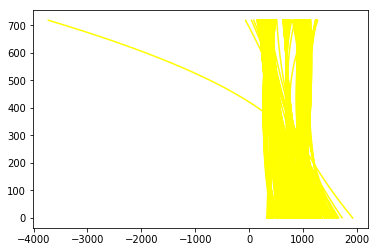

In [79]:
video_output2 = 'solved_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
processed_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(video_output2, audio=False)

In [80]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(video_output2))